# ΓΙΝΕΤΑΙ ΧΡΗΣΗ FREE PASS ΚΑΙ ΟΧΙ ΠΟΛΙΤΙΚΗ ΓΙΑ ΚΑΘΥΣΤΕΡΗΜΕΝΕΣ ΑΣΚΗΣΕΙΣ, ΕΙΧΑΜΕ ΧΡΗΣΙΜΟΠΟΙΗΣΕΙ 2 FREE PASS ΚΑΙ ΤΩΡΑ ΑΛΛΑ 2.

# ΑΣΚΗΣΗ 1
Βασίλης Πουλος, 2805  
Κωστάκης Ελευθέριος-Παναγιώτης, 2741

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import json
import time 
import sklearn.linear_model as linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import gensim
import nltk
from nltk.tokenize import word_tokenize
import string as string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
dataset_path = '../yelp-dataset/' # Change this path to match your local dataset folder path

business_filename = 'yelp_academic_dataset_business.json'
review_filename = 'yelp_academic_dataset_review.json'

# Reading business file
start = time.time()

list_business = []
categories_order = ['Beauty & Spas', 'Shopping', 'Bars']

with open(dataset_path + business_filename, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] >= 10 and \
            json_dict['categories'] is not None:
                cat = [x.strip(" ") for x in json_dict['categories'].split(",")]
                if "Beauty & Spas" in cat:
                    temp_cat = "Beauty & Spas"
                    list_business.append([json_dict['business_id'], temp_cat])
                elif "Shopping" in cat:
                    temp_cat = "Shopping"
                    list_business.append([json_dict['business_id'], temp_cat])
                elif "Bars" in cat:
                    temp_cat = "Bars"
                    list_business.append([json_dict['business_id'], temp_cat]) 

stop = time.time()
print("Read file in {:.3f} seconds".format(stop-start))

df_buisness = pd.DataFrame(list_business, columns=['business_id', 'categories'])
display(df_buisness.head())
print('{} businesses in df_buisness'.format(df_buisness['business_id'].size))

Read file in 2.268 seconds


,business_id,categories
0,cicPsia8Wj-DNRkmLbD_xg,Bars
1,xVXyrTWbG8U3szze-aA7eg,Bars
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas
3,C9keC4mWuXdl2mYFHZXudQ,Shopping
4,PFS9kf3U-ZCvpqay3AaNnQ,Shopping


2991 businesses in df_buisness


In [3]:
# Extracting unique buisness ids
np_businesses = np.array(list_business)
np_businesses_ids = np_businesses[:,0]
np_businesses_ids

array(['cicPsia8Wj-DNRkmLbD_xg', 'xVXyrTWbG8U3szze-aA7eg',
       'e-tRKAC-q40SqQfAOwYa-A', ..., 'wjqOdj0XJUDOOtU9LjRlWQ',
       'AqpB2IoLkUupDCuH-hmVdg', '0hudPyuCBlKg79OwKBw-eQ'], dtype='<U22')

In [4]:
def find_buisness_index(business_id):
    index = np.where(np_businesses_ids == business_id)[0]
    return index

# Reading reveiws file
start = time.time()
business_reviews = [[] for i in range(int(len(np_businesses_ids)))]

with open(dataset_path + review_filename, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = find_buisness_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_reviews[index[0]]) == 0:
                business_reviews[index[0]] = json_dict['text']
            else:
                business_reviews[index[0]] += json_dict['text']

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 5.521 mins


In [5]:
df_business_reviews = pd.DataFrame(business_reviews, columns=['reviews as a single string for each buisness'])
df_business_reviews

,reviews as a single string for each buisness
0,"Consistently good, as the Keg tends to be.\n\n..."
1,I would give zero stars. I came here with a gr...
2,A blissful experience! I highly recommended th...
3,If you're a boy and you want to wear some hot ...
4,"As a country girl, I often find myself missing..."
...,...
2986,Good tacos in the downtown core are hard to co...
2987,This used to be my favourite place. It was alw...
2988,Very welcoming place. Great setup and super fr...
2989,I can't beleive I am saying this... but I left...


In [6]:
# Load custom stopwords 
# source: https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = text.ENGLISH_STOP_WORDS.union(lines)

# Allowing words that are alpharithmetics more than 2 chars, excluding
# common words that exist in more than max_df of docs and rare words that
# exist in less than min_df of docs.
tfidf = TfidfVectorizer(min_df=0.25,
                        max_df=0.85,
                        max_features=8000,
                        token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b',
                        lowercase=True,
                        stop_words=stop_words)


In [7]:
# True values table: Μatching categories to numbers
true_labels = np_businesses[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 

Here the idea is to split the whole dataset into five sections using k-fold cross validation. 
In the end we will have a list for training data (input_train) and training labels (output_train),
training data list should have size 5 and will store lists with reviews, similar we create output_train.
So we have input_train which contains lists within a list, 5x2392, every time 2392 should be the
training dataset size and 2991-2392= 599 is the testing dataset. We keep also the true labels for 
testing dataset in the output_test list of lists (5x599).


In [8]:
kf = KFold(n_splits = 5,shuffle = True)

input_train = [] # X
input_test = []  # X_test
output_train = [] # y
output_test = []

for train_index, test_index in kf.split(business_reviews):
    for i in range(len(train_index)):
        input_train.append(business_reviews[train_index[i]])
        output_train.append(np.asarray(true_labels)[train_index[i]])

    for i in range(len(test_index)):
        input_test.append(business_reviews[test_index[i]])
        output_test.append(np.asarray(true_labels)[test_index[i]])

        
input_train =  [input_train[0:2392], input_train[2392:4785], input_train[4785:7178],
               input_train[7178:9571], input_train[9571:]]
output_train = [output_train[0:2392], output_train[2392:4785], output_train[4785:7178],
                output_train[7178:9571], output_train[9571:]]

input_test = [input_test[0:599], input_test[599:1197], input_test[1197:1795],
              input_test[1795:2393], input_test[2393:]]
output_test =[output_test[0:599], output_test[599:1197], output_test[1197:1795],
              output_test[1795:2393], output_test[2393:]]

### Helping function for confusion matrix plots

In [9]:
def display_confusion_matrix(title, cfm_data):
    plt.title(title)
    plt.axis('square')
    sns.heatmap(cfm_data, annot=True, cmap='Blues', 
                cbar=False, fmt='.1f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## kNN method

/home/left/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


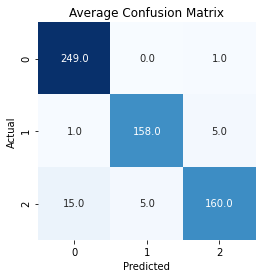

Average accuracy is 0.950515072500991
Average F1 Score is 0.9500268202560285
Average Precision Score is 0.9512447649688054
Average recall score is 0.950515072500991


In [10]:
average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    
    classifier = KNeighborsClassifier(n_neighbors = 5, p=2) #Euclidean distance
    classifier = classifier.fit(X, output_train[i])
    
    y_pred = classifier.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted')
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

## SVM method with Gaussian kernel (rbf)

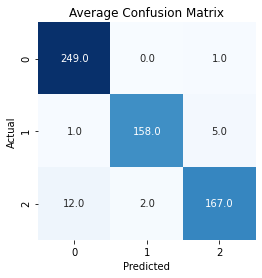

Average accuracy is 0.9615468367010793
Average F1 Score is 0.9613641056106882
Average Precision Score is 0.9619917713067491
Average recall score is 0.9615468367010793


In [11]:
average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    svm = SVC(kernel='rbf', gamma='scale') # Gaussian Kernel
    svm = svm.fit(X, output_train[i])
    
    y_pred = svm.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')
    
display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

## SVM method with linear kernel

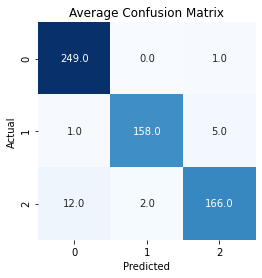

Average accuracy is 0.9612129468847186
Average F1 Score is 0.9610258997844856
Average Precision Score is 0.9616789458564776
Average recall score is 0.9612129468847186


In [12]:
average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    svm = SVC(kernel='linear', gamma='scale') # Linear Kernel
    svm = svm.fit(X, output_train[i])
    
    y_pred = svm.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

## We use LBFGS algorithm for optimization or newton-cg the result is pretty much the same.

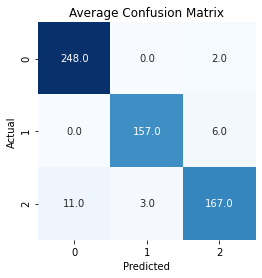

Average accuracy is 0.9585356865679142
Average F1 Score is 0.9583699410870434
Average Precision Score is 0.9587909973598879
Average recall score is 0.9585356865679142


In [13]:
average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    linear_clf = linear_model.LogisticRegression(solver='newton-cg')
    linear_clf.fit(X, output_train[i])
    
    y_pred = linear_clf.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)



It might be a coincidence.

If we have to say something about it, then it indicates that sensitivity (a.k.a. recall, or TPR) is equal to specificity (a.k.a. selectivity, or TNR), and thus they are also equal to accuracy. TP / P = TN / N = (TP+TN) / (P+N), where P = TP+FN, N = TN+FP.

This means your model is somehow "balanced", that is, its ability to correctly classify positive samples is same as its ability to correctly classify negative samples.

However, the importance of sensitivity and specificity may vary from case to case, so being "balanced" is not necessarily good.





As OP has mentioned, this is just a coincidence. It's highly likely that number of instances in each class is balanced. Recall = TP/P and Acc = (TP + TN)/(P+N), so in your case TP/P = TN/N. This can happen, and is more likely to happen when |P| = |N|

Try following: Print upto 7-8 places of decimal and you may see some difference.

Second try to imbalance the problem. Like set positive class as just 20% of total and let rest be 80%, you should definitely see the difference.




As OP has mentioned, this is just a coincidence. It's highly likely that number of instances in each class is balanced. Recall = TP/P and Acc = (TP + TN)/(P+N), so in your case TP/P = TN/N. This can happen, and is more likely to happen when |P| = |N|

Try following: Print upto 7-8 places of decimal and you may see some difference.

Second try to imbalance the problem. Like set positive class as just 20% of total and let rest be 80%, you should definitely see the difference.




## B

### First download Google's word embedding dataset

In [14]:
filepath = '/home/left/github/data-mining-3/GoogleNews-vectors-negative300.bin'
g_model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)

### Load our stopwords file:

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Load custom stopwords 
# source: https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = text.ENGLISH_STOP_WORDS.union(lines)

### Method to get embedding mean value for each review, finally X_train and X_test are arrays 2393x300 and 598x300 respectively.

In [16]:
def get_train_test_data(input_train, input_test):

    X_train_input = []
    for x in input_train:
        wt = word_tokenize(x.lower())
        doc = [w for w in wt if (w not in stop_words) and (w not in string.punctuation)]
        if len(doc) == 0: continue
        X_train_input.append(doc)
    
    X_train = []    
    for x in X_train_input:
        vx = np.zeros(300)
        length = 0
        for w in x:
            if w in g_model.wv:
                length += 1
                vx += g_model[w]
        if length != 0: vx /= length
        X_train.append(vx)

    X_test_input = []
    for x in input_test:
        wt = word_tokenize(x.lower())
        doc = [w for w in wt if (w not in stop_words) and (w not in string.punctuation)]
        if len(doc) == 0: continue
        X_test_input.append(doc)
    
    
    X_test = []
    for x in X_test_input:
        vx = np.zeros(300)
        length = 0
        for w in x: 
            if (w not in g_model.wv): continue
            length += 1
            vx += g_model.wv[w]
        if length != 0: vx /= length
        X_test.append(vx)
    
    return X_train, X_test

## kNN method with 5 neighbors

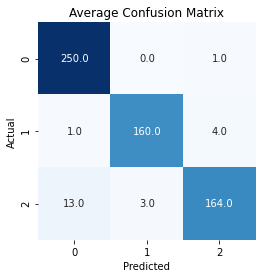

Average accuracy is 0.960545725596172
Average F1 Score is 0.9602308641182518
Average Precision Score is 0.9612280663353152
Average recall score is 0.960545725596172
Finished in 15.615 mins


In [17]:
start = time.time()

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X_train, X_test = get_train_test_data(input_train[i], input_test[i])
    
    classifier = KNeighborsClassifier(n_neighbors = 5, p=2) #Euclidean distance
    classifier = classifier.fit(X_train, output_train[i])
    
    y_pred = classifier.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted')
    average_recall += recall_score(output_test[i], y_pred, average='weighted')
    
display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

stop = time.time()
print("Finished in {:.3f} mins".format((stop-start)/60))

## SVM method with Gaussian kernel

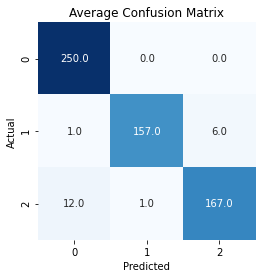

Average accuracy is 0.9628846293432197
Average F1 Score is 0.9627243379688297
Average Precision Score is 0.9636344837469328
Average recall score is 0.9628846293432197
Finished in 15.576 mins


In [18]:
start = time.time()

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    
    X_train, X_test = get_train_test_data(input_train[i], input_test[i])

    svm = SVC(kernel='rbf', gamma='scale') # Gaussian Kernel
    svm = svm.fit(X_train, output_train[i])
    
    y_pred = svm.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')
    
display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

stop = time.time()
print("Finished in {:.3f} mins".format((stop-start)/60))

## Linear Regression Method

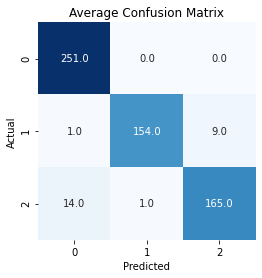

Average accuracy is 0.9541912105460048
Average F1 Score is 0.9539319169891145
Average Precision Score is 0.9551666078660046
Average recall score is 0.9541912105460048
Finished in 16.188 mins


In [19]:
start = time.time()

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X_train, X_test = get_train_test_data(input_train[i], input_test[i])
    
    linear_clf = linear_model.LogisticRegression(solver='newton-cg')
    linear_clf.fit(X_train, output_train[i])
    
    y_pred = linear_clf.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

stop = time.time()
print("Finished in {:.3f} mins".format((stop-start)/60))

## Conclusion

The results are pretty much the same using either tfidf or word embedding models for feature extraction.
We could save time by calculating one time all tfidf values at first for the whole dataset and do it similar 
for text embedding method. Although that way gives similar results, we chose the correct way, we fit only the
training dataset each time leaving out the testing dataset.